In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

try:
  import torchinfo
except:
  %pip install torchinfo
  import torchinfo

from torchinfo import summary

from tqdm.auto import tqdm

import random
import os
from typing import List , Dict , Tuple
from timeit import default_timer as timer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn
import numpy as np

### Create directory for training results

In [35]:
model_name = "ResNet18"
run_id = f"251108_{model_name}_2"
base_directory = "/content/drive/MyDrive/TAI/sem2/DL"
project_directory = os.path.join(base_directory, run_id)
os.makedirs(project_directory, exist_ok=True)

### Setup device agnostic code

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data augmentation

In [12]:
tensor_cifar10 = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t ,_ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [13]:
print(f"Mean: {imgs.view(3,-1).mean(dim=1)}")
print(f"Std: {imgs.view(3,-1).std(dim=1)}")

# Mean: tensor([0.4914, 0.4822, 0.4465])
# Std: tensor([0.2470, 0.2435, 0.2616])

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [14]:
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.2435, 0.2616]

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1,contrast=0.1, saturation=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
])

# Load CIFAR-10 dataset

In [15]:
train_data = datasets.CIFAR10(root="data", train=True, transform=data_transform)
test_data = datasets.CIFAR10(root="data", train=False, transform=data_transform)
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Examples of training dataset after augumentation

Sample images saved to: /content/drive/MyDrive/TAI/sem2/DL/251108_ResNet18_2/sample_augmented_images.png


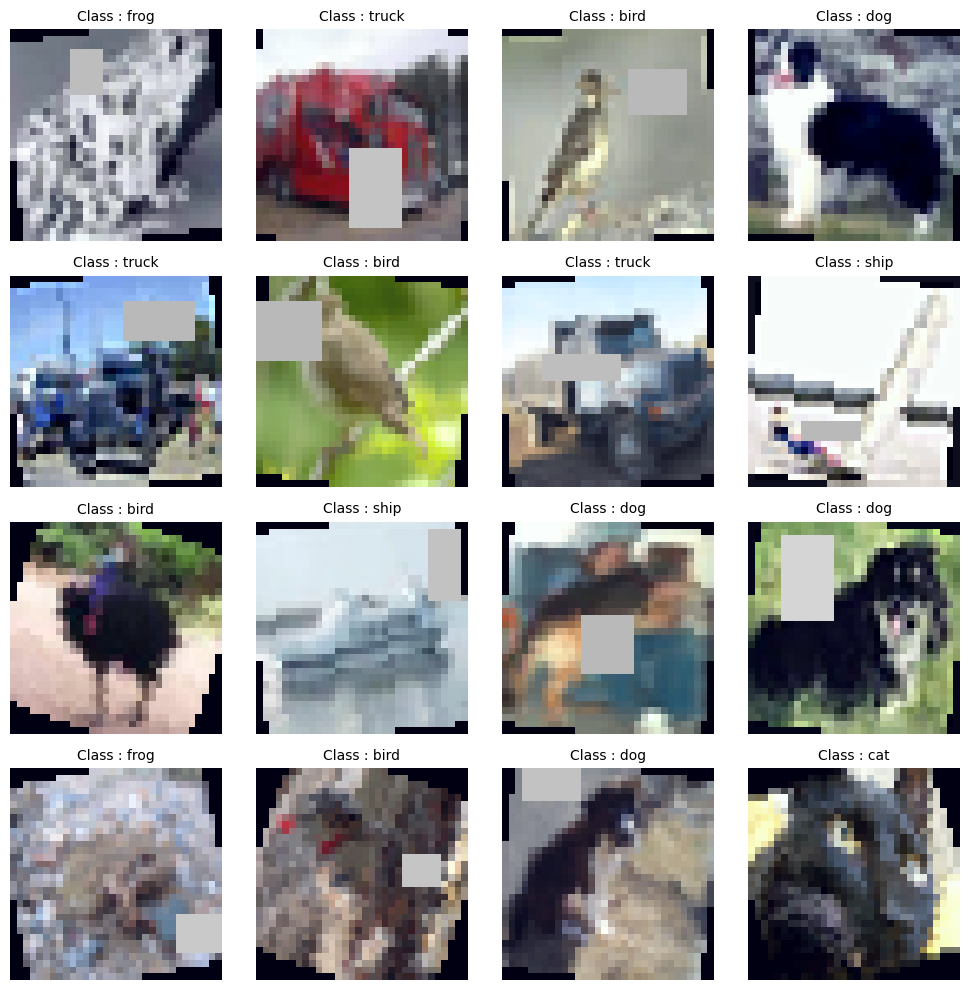

In [37]:
rand_idx = random.sample(range(len(train_data)), k=16)

plt.figure(figsize=(10,10))

for i, idx in enumerate(rand_idx):
  img, label = train_data[idx]

  img = (img - img.min()) / (img.max() - img.min()) # the image tensor's range is not between 0 and 1,
                                                    # so we have to scale the tensor values into range 0 and 1 to prevent error
  img_class = class_names[label]

  plt.subplot(4,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class : {img_class}",fontsize=10)
  plt.axis(False)

plt.tight_layout()
plt.savefig(os.path.join(project_directory, "sample_augmented_images.png"))
print(f"Sample images saved to: {os.path.join(project_directory, 'sample_augmented_images.png')}")
plt.show()

In [17]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 800 # IMPORTANT!!

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

### Helper functions used for training and testing

In [18]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer, # algorithm for weights update
               scheduler:torch.optim.lr_scheduler, # learning rate moderator
               grad_clip:float): # gradient clipping

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X) # forward pass (returns logits)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad() # CRUCIAL!!! pytorch automaticaly sums the gradients, this function zeroes the gradients from previous batch
    loss.backward() # backward pass (calculates loss gradients for each weight)

    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip) # do we need it?? (it helps with exploding gradient problem)

    optimizer.step() # weights update
    y_pred_class = torch.argmax(y_pred, dim=1) # choses class with biggest logit
    train_acc += (y_pred_class == y).sum().item() / len(y)

  train_loss /= len(dataloader) # avg loss for the epoch
  train_acc /= len(dataloader)

  if scheduler is not None:
    scheduler.step(train_loss) # update lr based on loss

  return train_loss, train_acc

In [19]:
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode(): # saves memory and speeds up computations
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = torch.argmax(test_pred_logits, dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [20]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          grad_clip:float,
          loss_fn: torch.nn.Module,
          epochs: int):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, scheduler, grad_clip)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

    return results

In [21]:
def plot_loss_curves(results: Dict[str, List[float]], save_path: str = None, model_name: str = None, learning_rate: float = None, weight_decay: float = None, grad_clip: float = None):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    title_suffix = model_name
    if learning_rate is not None: title_suffix += f" | Learning rate: {learning_rate}"
    if weight_decay is not None: title_suffix += f" | Weight decay: {weight_decay}"
    if grad_clip is not None: title_suffix += f" | Grad clip: {grad_clip}"
    title_suffix += f" | Epochs: {len(results['train_loss'])}"
    title_suffix += f" | Batch size: {BATCH_SIZE}"

    plt.figure(figsize=(15, 7))
    plt.suptitle(title_suffix, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title(f'Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title(f'Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

    plt.tight_layout() # Adjust layout to prevent suptitle overlap
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to: {save_path}")
    plt.show()

# Resnet architecture


In [22]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, input_channels, output_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3,
                      stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or input_channels != output_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.main_path(x) + self.shortcut(x)
        out = self.relu(out)
        return out

In [23]:
class ResNet18(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = nn.Sequential(
            BasicBlock(input_channels=64, output_channels=64, stride=1),
            BasicBlock(input_channels=64, output_channels=64, stride=1)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(input_channels=64, output_channels=128, stride=2),
            BasicBlock(input_channels=128, output_channels=128, stride=1)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(input_channels=128, output_channels=256, stride=2),
            BasicBlock(input_channels=256, output_channels=256, stride=1)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(input_channels=256, output_channels=512, stride=2),
            BasicBlock(input_channels=512, output_channels=512, stride=1)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.classifier(out)
        return out

In [24]:
class ResNet9(nn.Module):
    def conv_block(self, input_channels, output_channels, use_pool=False):
        layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(output_channels),
                  nn.ReLU(inplace=True)]
        if use_pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def __init__(self, input_channels, number_classes): # define the layers
        super().__init__()

        self.conv1 = self.conv_block(input_channels, 64)
        self.conv2 = self.conv_block(64, 128, use_pool=True)
        self.residual1 = nn.Sequential(
                          self.conv_block(128, 128),
                          self.conv_block(128, 128)
                        )

        self.conv3 = self.conv_block(128, 256, use_pool=True)
        self.conv4 = self.conv_block(256, 512, use_pool=True)
        self.residual2 = nn.Sequential(
                          self.conv_block(512, 512),
                          self.conv_block(512, 512)
                        )

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, number_classes))

    def forward(self, xb): # define data flow from defined layers
        layer1 = self.conv1(xb)
        layer2 = self.conv2(layer1)
        residual1 = self.residual1(layer2) + layer2 # res(net_output) = F(layer2) + layer2
        layer3 = self.conv3(residual1)
        layer4 = self.conv4(layer3)
        residual2 = self.residual2(layer4) + layer4
        class_output = self.classifier(residual2)
        return class_output # (batch_size, number_classes) with logits for loss function

# Model training

In [36]:
model = ResNet18(3,10).to(device) # model object, 3 channels, 10 classes
summary(model, input_size=[1, 3, 32, 32]) #[batch_size, color_channels, width, height]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-4                   [1, 64, 32, 32]           --
│    │    └─Sequential: 3-1              [1, 64, 32, 32]           73,984
│    │    └─Sequential: 3-2              [1, 64, 32, 32]           --
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    └─BasicBlock: 2-5                   [1, 64, 32, 32]           --
│    │    └─Sequential: 3-4              [1, 64, 32, 32]           73,984
│    │    └─Sequential: 3-5              [1, 64, 32, 32]           --
│  

In [38]:
NUM_EPOCHS = 30 # more epochs (from 20)
learning_rate = 0.001 # reduce learning rate (from 0.01)
weight_decay = 35e-5 # reduced (from 15e-5)
# weight_decay = None
grad_clip = 0.0001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
              optimizer=optimizer, mode='min', factor=0.3, patience=3, threshold=0.09)

start_time = timer()
model_results = train(model, train_dataloader, test_dataloader, optimizer, scheduler, grad_clip, loss_fn, NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6506 | train_acc: 0.3983 | test_loss: 1.6936 | test_acc: 0.3772
Epoch: 2 | train_loss: 1.2237 | train_acc: 0.5590 | test_loss: 1.5344 | test_acc: 0.4684
Epoch: 3 | train_loss: 1.0453 | train_acc: 0.6285 | test_loss: 1.3163 | test_acc: 0.5466
Epoch: 4 | train_loss: 0.9187 | train_acc: 0.6770 | test_loss: 1.6728 | test_acc: 0.4418
Epoch: 5 | train_loss: 0.8393 | train_acc: 0.7049 | test_loss: 1.0511 | test_acc: 0.6371
Epoch: 6 | train_loss: 0.7820 | train_acc: 0.7261 | test_loss: 1.0029 | test_acc: 0.6476
Epoch: 7 | train_loss: 0.7339 | train_acc: 0.7457 | test_loss: 1.0424 | test_acc: 0.6499
Epoch: 8 | train_loss: 0.7166 | train_acc: 0.7513 | test_loss: 1.4742 | test_acc: 0.5342
Epoch: 9 | train_loss: 0.7057 | train_acc: 0.7558 | test_loss: 0.9151 | test_acc: 0.6814
Epoch: 10 | train_loss: 0.6724 | train_acc: 0.7670 | test_loss: 1.2698 | test_acc: 0.5749
Epoch: 11 | train_loss: 0.6596 | train_acc: 0.7722 | test_loss: 1.1293 | test_acc: 0.6045
Epoch: 12 | train_l

Plot saved to: /content/drive/MyDrive/TAI/sem2/DL/251108_ResNet18_2/model_ResNet18_loss_curves.png


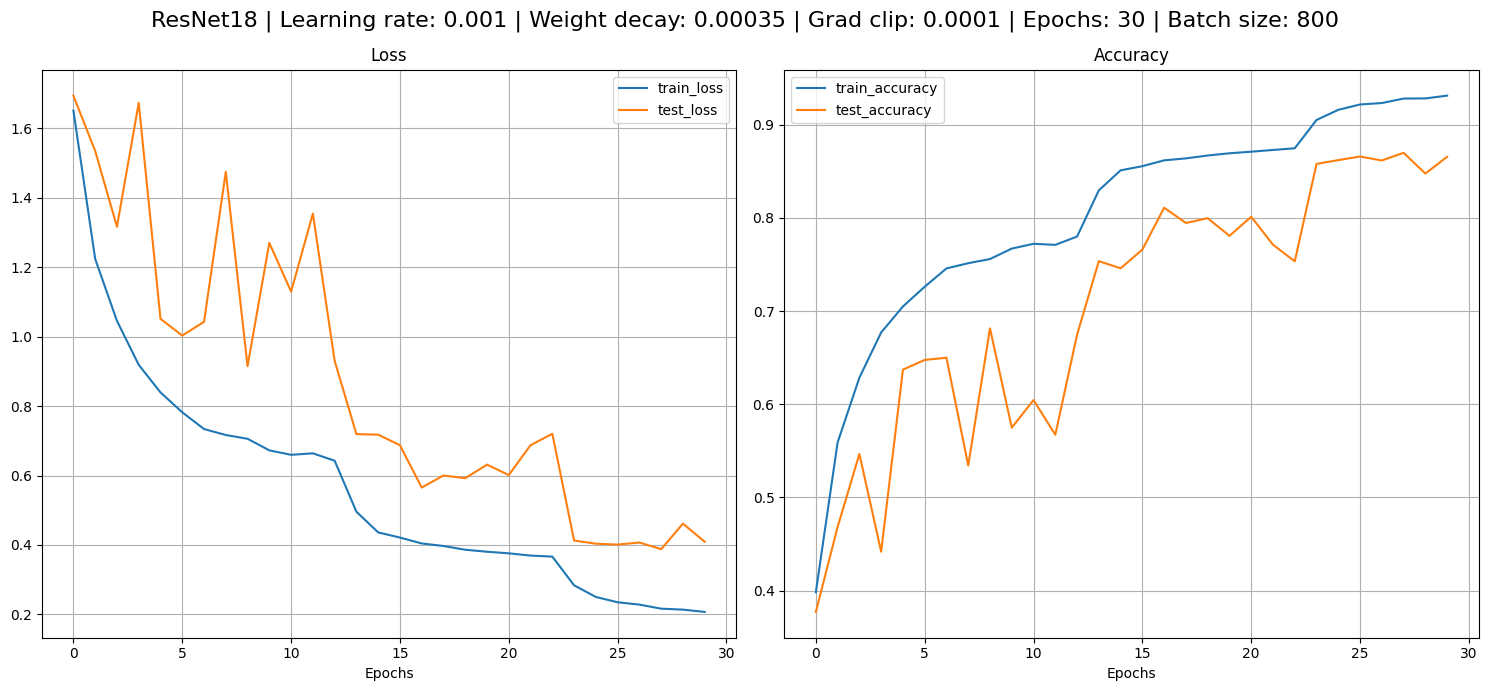

In [39]:
plot_loss_curves(model_results, save_path=os.path.join(project_directory, f"model_{model_name}_loss_curves.png"), model_name=model_name, learning_rate=learning_rate, weight_decay=weight_decay, grad_clip=grad_clip)

### Extra training


In [40]:
NUM_EPOCHS = 30 # additional epochs for model

start_time = timer()
model_results_exten = train(model, train_dataloader, test_dataloader, optimizer, scheduler, grad_clip, loss_fn, NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2032 | train_acc: 0.9329 | test_loss: 0.4048 | test_acc: 0.8648
Epoch: 2 | train_loss: 0.1946 | train_acc: 0.9351 | test_loss: 0.4177 | test_acc: 0.8642
Epoch: 3 | train_loss: 0.1898 | train_acc: 0.9364 | test_loss: 0.4083 | test_acc: 0.8620
Epoch: 4 | train_loss: 0.1870 | train_acc: 0.9367 | test_loss: 0.4046 | test_acc: 0.8653
Epoch: 5 | train_loss: 0.1826 | train_acc: 0.9389 | test_loss: 0.4072 | test_acc: 0.8667
Epoch: 6 | train_loss: 0.1731 | train_acc: 0.9414 | test_loss: 0.4434 | test_acc: 0.8576
Epoch: 7 | train_loss: 0.1766 | train_acc: 0.9414 | test_loss: 0.4140 | test_acc: 0.8657
Epoch: 8 | train_loss: 0.1725 | train_acc: 0.9427 | test_loss: 0.3896 | test_acc: 0.8709
Epoch: 9 | train_loss: 0.1647 | train_acc: 0.9448 | test_loss: 0.4233 | test_acc: 0.8589
Epoch: 10 | train_loss: 0.1611 | train_acc: 0.9458 | test_loss: 0.4419 | test_acc: 0.8589
Epoch: 11 | train_loss: 0.1257 | train_acc: 0.9597 | test_loss: 0.3550 | test_acc: 0.8879
Epoch: 12 | train_l

In [41]:
# merge results
for key in model_results.keys():
  model_results[key].extend(model_results_exten[key])

Plot saved to: /content/drive/MyDrive/TAI/sem2/DL/251108_ResNet18_2/model_exten_ResNet18_loss_curves.png


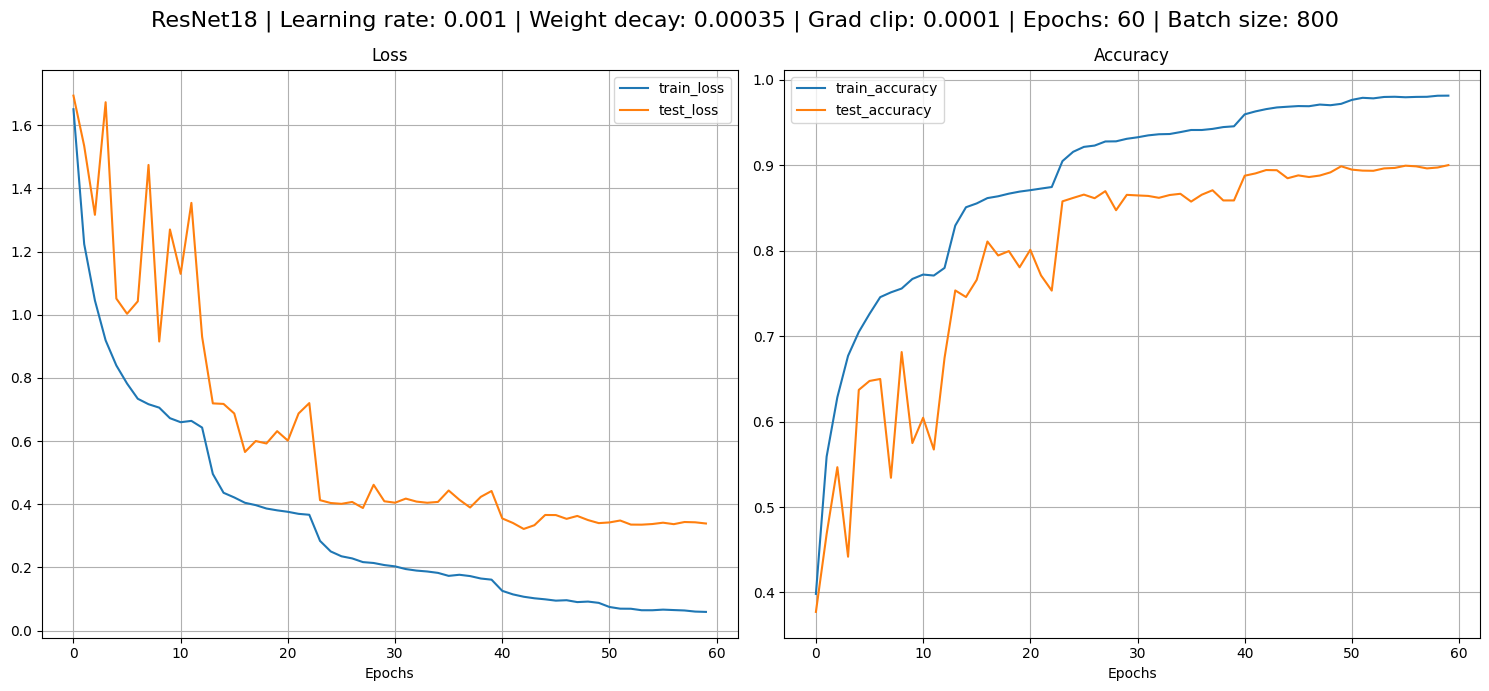

In [42]:
plot_loss_curves(model_results, save_path=os.path.join(project_directory, f"model_exten_{model_name}_loss_curves.png"), model_name=model_name, learning_rate=learning_rate, weight_decay=weight_decay, grad_clip=grad_clip)

# Make predictions using trained model

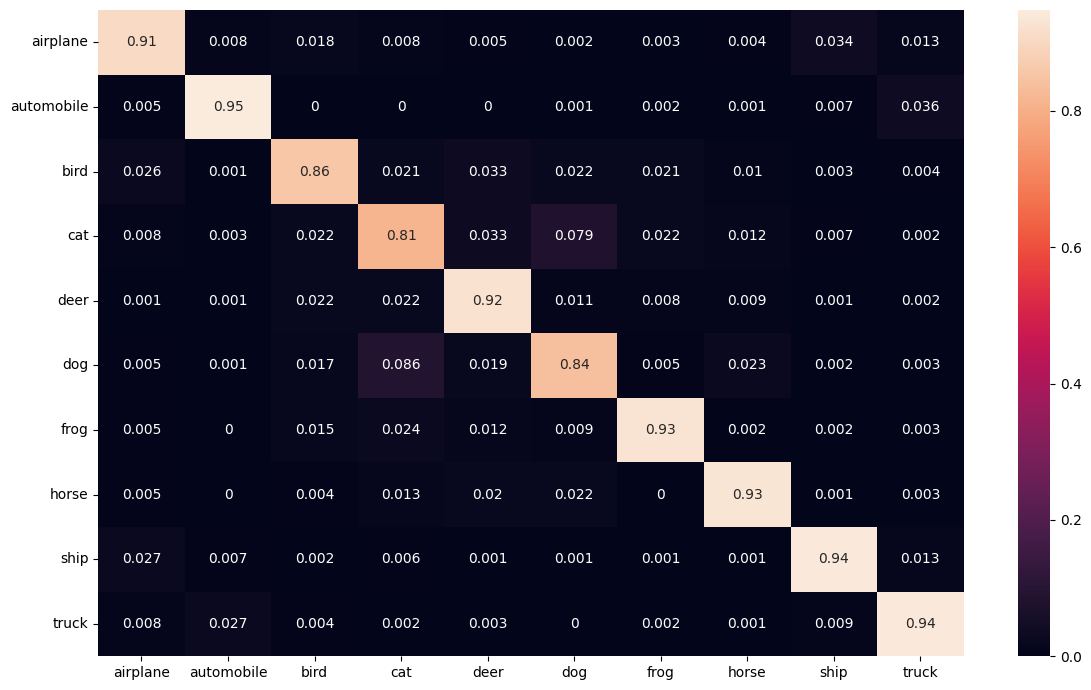

In [43]:
predicted_labels = []
actual_labels = []

model.eval()

with torch.no_grad():  # We are using no_grad instead of inference_mode for better compatibility
  for images, labels in DataLoader(dataset=test_data, batch_size=1, num_workers=NUM_WORKERS):
    images, labels = images.to(device), labels.to(device)
    prediction_logits = model(images)

    predictions = prediction_logits.argmax(dim=1).cpu().numpy()
    predicted_labels.extend(predictions)
    true_labels = labels.cpu().numpy()
    actual_labels.extend(true_labels)

confusion_mat = confusion_matrix(actual_labels, predicted_labels)
confusion_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat)*10, index=class_names, columns=class_names)

plt.figure(figsize=(12,7))
sn.heatmap(confusion_df, annot=True)
plt.tight_layout()
plt.savefig(os.path.join(project_directory, f"confusion_matrix_model_{model_name}.png"))
plt.show()

In [44]:
report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print(report)

with open(os.path.join(project_directory, f"classification_report_{model_name}.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.89      0.86      0.88      1000
         cat       0.82      0.81      0.81      1000
        deer       0.88      0.92      0.90      1000
         dog       0.85      0.84      0.84      1000
        frog       0.94      0.93      0.93      1000
       horse       0.94      0.93      0.93      1000
        ship       0.93      0.94      0.94      1000
       truck       0.92      0.94      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Saving the trained model

In [45]:
model_name = f"model_{model_name}_cifar10.pth"
model_save_file = os.path.join(project_directory, model_name)
torch.save(model.state_dict(), model_save_file)

print(f"Model saved to: {model_save_file}")

Model saved to: /content/drive/MyDrive/TAI/sem2/DL/251108_ResNet18_2/model_ResNet18_cifar10.pth


### Loading the saved model

In [46]:
loaded_model = ResNet18(3, 10).to(device)
loaded_model.load_state_dict(torch.load(model_save_file))
loaded_model.eval()

summary(loaded_model, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-4                   [1, 64, 32, 32]           --
│    │    └─Sequential: 3-1              [1, 64, 32, 32]           73,984
│    │    └─Sequential: 3-2              [1, 64, 32, 32]           --
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    └─BasicBlock: 2-5                   [1, 64, 32, 32]           --
│    │    └─Sequential: 3-4              [1, 64, 32, 32]           73,984
│    │    └─Sequential: 3-5              [1, 64, 32, 32]           --
│  